# Introduction

In this code we are gonna write DDQN, which is an extension of DQN that tries to minimize the over-estimation of *state/values* which is typical of the DQN algorithm.

## Importing Section

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math, random
import matplotlib.pyplot as plt

import gym

from IPython.display import clear_output
from collections import deque
from wrap import make_atari, wrap_deepmind, wrap_pytorch

In [2]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)
env    = gym.wrappers.Monitor(env, "./vid" , video_callable=lambda episode_id: (episode_id+1)%10==0, force = True)

## Device selection

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Buffer

In [4]:
class Buffer():
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, is_done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        self.buffer.append((state, action, reward, next_state, is_done))
    
    def sample(self, batch_size):
        states, actions, rewards, next_states, is_dones = zip(*random.sample(self.buffer, batch_size))
        
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        
        return states, actions, rewards, next_states, is_dones
    
    def __len__(self):
        return len(self.buffer)

## Epsilon-Decay

In [5]:
def epsilon_decay_f(iteration, epsilon_init = 1.0, epsilon_final = 0.01, decay_every = 500):
    epsilon = epsilon_final - (epsilon_final - epsilon_init)*math.exp(-1. * iteration/decay_every)
    return epsilon

## Loss Function

In [6]:
def Loss(agent, tg_agent, buffer, batch_size, device, optimizer):
    states, actions, rewards, next_states, is_dones = buffer.sample(batch_size)
    
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    is_dones = torch.FloatTensor(is_dones).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    
    # Io devo selezionarli con agent e valutarli con tg
    
    next_Q_actions = agent(next_states).max(1)[1].detach()
    next_Q_values = tg_agent(next_states)
    next_Q_values = next_Q_values.gather(1, next_Q_actions.unsqueeze(1)).squeeze(1)
    
    Q_values = agent(states)
    Q_values = Q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    
    bootstrap = rewards + 0.99 * next_Q_values * (1.0 - is_dones)
    
    loss = (bootstrap.detach() - Q_values).pow(2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss   

## Update Function

In [7]:
def update(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

## Agent 

In [8]:
class Agent(nn.Module):
    def __init__(self, obs_space, action_space, device):
        super(Agent, self).__init__()
        self.obs_space = obs_space
        self.action_space = action_space
        self.num_channels_in = self.obs_space[0]
        self.device = device
        
        self.img_extractor = nn.Sequential(
            nn.Conv2d(self.num_channels_in, 32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1), 
            nn.ReLU())
        
        self.fc = nn.Sequential(
            nn.Linear(self.get_size_after_img_ext(), 512),
            nn.ReLU(),
            nn.Linear(512, self.action_space))
        
    def forward(self, state):
        state = self.img_extractor(state)
        state = state.view(state.size(0), -1)
        output = self.fc(state)
        return output
        
    def get_size_after_img_ext(self):
        example_img = torch.zeros(1, *self.obs_space)
        shape_after_img_ext = self.img_extractor(example_img)
        #print(shape_after_img_ext.size())
        size_after_img_ext = np.prod(shape_after_img_ext.size())
        return size_after_img_ext
    
    def act(self, state, epsilon):
        if random.random()<epsilon:
            action = random.randrange(self.action_space)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)       
            q_value = self.forward(state)
            action = q_value.max(1)[1].cpu().numpy()[0]
            #print(action.shape)
            #print(action)
        return action
    
    def play(self, state):
        # Playing greedy
        
        while True:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            output = self.forward(state)
            action = output.max(1)[1].detach().cpu().numpy()[0]
            next_state, reward, is_done, _ = env.step(action)
            
            if is_done == True:
                break

## Plotting

In [9]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [10]:
# Instatiating Object

agent = Agent(env.observation_space.shape, env.action_space.n, device).to(device)
tg_agent = Agent(env.observation_space.shape, env.action_space.n, device).to(device)
update(agent, tg_agent)
optimizer = optim.Adam(agent.parameters(), lr = 0.0001)

capacity = 100000
buffer = Buffer(capacity)

batch_size = 32
num_episodes = 200

plot_every = 200
update_net_every = 100

## Training Function

In [11]:
# Needed 

# num_episodes, epsilon_decay, agent, buffer, initial_replay, update_f, tg_agent, 
# plot every, update_every, update_net

# ad update_f far passare, buffer, agent, tg_agent

# To Do 

# verificare come buffer prende i valori di push

def training ( agent, tg_agent, buffer, env, device, num_episodes, batch_size, plot_every, update_net_every ):
    losses = []
    episodes_rewards = []
    episode_rew = 0
    ep = 1
    
    state = env.reset()
    num_iterations = 0 # Useful for epsilon_decay
    
    while ep <= num_episodes:
        epsilon = epsilon_decay_f(num_iterations)
        action = agent.act(state, epsilon) 
        
        next_state, reward, is_done, _ = env.step(action)
        buffer.push(state, action, reward, next_state, is_done)
        
        episode_rew += reward
        state = next_state
        num_iterations += 1
        
        if is_done == True:
            #print(episode_rew)
            episodes_rewards.append(episode_rew)
            episode_rew = 0
            ep += 1
            state = env.reset()
        
        if len(buffer) > 100:
            loss = Loss(agent, tg_agent, buffer, batch_size, device, optimizer)
            losses.append(loss)
            
        if num_iterations % plot_every == 0:
            #print(num_iterations)
            plot(num_iterations, episodes_rewards, losses)
            
        if num_iterations % update_net_every == 0:
            #print('UPDATE')
            update(agent, tg_agent)
            
       

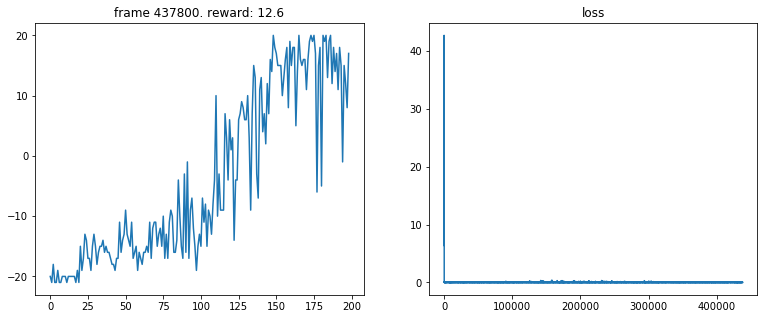

In [12]:
training(agent, tg_agent, buffer, env, device, num_episodes, batch_size, plot_every, update_net_every)